# Transformer Layer

## Definition

**Inputs:**
* $X \in \mathbb{R}^{N \times d},\quad  N\in \mathbb{N}$. 

**Weights:**

MultiHeadSelfAttention
* $ W_{q,i} \in \mathbb{R}^{d \times d_h}$ and $b_{q,i}\in \mathbb{R}^{d_h}$, $\quad i=1,2,\dots,h.$
* $W_{k,i} \in \mathbb{R}^{d \times d_h}$ and $b_{k,i}\in \mathbb{R}^{d_h}$, $\quad i=1,2,\dots,h.$
* $W_{v,i} \in \mathbb{R}^{d \times d_h}$ and $b_{v,i}\in \mathbb{R}^{d_h}$, $\quad i=1,2,\dots,h.$
* $\mathcal{W}_{i}=\{W_{q,i},b_{q,i},W_{k,i},b_{k,i},W_{v,i},b_{v,i}\}$, $\quad i=1,2,\dots,h.$
* $W_{o} \in \mathbb{R}^{d \times d }$ and $b_{o}\in \mathbb{R}^{d}$.
* $\mathcal{W}_{0}=\{W_{o},b_0\}$.

where $d = d_h\cdot h$ and $h$ number of heads.

Layer Normalizations
* scales $\gamma_1, \gamma_2 \in \mathbb{R}^{d}$ 
* shifts $\beta_1, \beta_2\in \mathbb{R}^{d}$ and $ \in \mathbb{R}^{d}$

MLP
* $W_{1} \in \mathbb{R}^{d \times d_{\text{ff}}}$ and $b_{1}\in \mathbb{R}^{d_{\text{ff}}}$.
* $W_{2} \in \mathbb{R}^{d_{\text{ff}} \times d}$ and $b_{2}\in \mathbb{R}^{d}$.

**Output (post-norm):**
* Output $O= [o_1|o_2|\dots|o_M]^T \in\mathbb{R}^{N\times d}$
\begin{align*}
O  &= \operatorname{TransformerEncoderLayer}(X),\\
&= \operatorname{LayerNorm}_{\gamma_2,\beta_2}\circ\operatorname{ResConn}_{\operatorname{MLP}}\circ\operatorname{LayerNorm}_{\gamma_1,\beta_1}\circ\operatorname{ResConn}_{\operatorname{MHSA}}(X),\\
\end{align*}
where:
$$
\begin{align*}
   \operatorname{MLP} &= \operatorname{Linear}_{W_2,b_2}\circ \operatorname{ReLU}\circ\operatorname{Linear}_{W_1,b_1},\\
   \operatorname{MHSA} &= \operatorname{MultiHeadSelfAttention}_{\{\mathcal{W}_{i}\}_{i=0}^h}
\end{align*}
$$

**Output  (pre-norm):**
* Output $O= [o_1|o_2|\dots|o_M]^T \in\mathbb{R}^{N\times d}$
\begin{align*}
O &= \operatorname{TransformerEncoderLayer}_{\text{pren}}(X),\\
 &= \operatorname{ResConn}_{\operatorname{MLPLN}}\circ\operatorname{ResConn}_{\operatorname{MHSALN}}(X),\\
\end{align*}
where:
$$
\begin{align*}
      \operatorname{MHSALN} &= \operatorname{MultiHeadSelfAttention}_{\{\mathcal{W}_{i}\}_{i=0}^h}\circ\operatorname{LayerNorm}_{\gamma_1,\beta_1},\\
      \operatorname{MLPLN} &= \operatorname{Linear}_{W_2,b_2}\circ \operatorname{ReLU}\circ\operatorname{Linear}_{W_1,b_1}\circ\operatorname{LayerNorm}_{\gamma_2,\beta_2}.
\end{align*}
$$

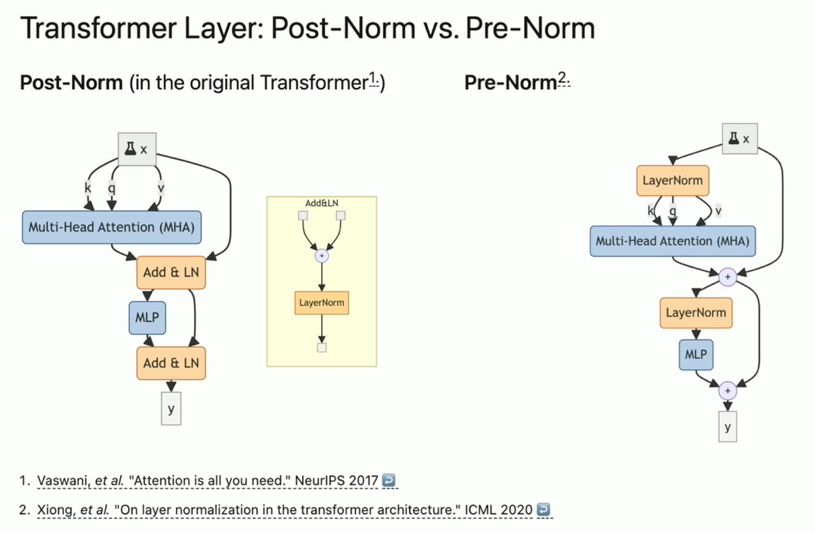

## Code

In [73]:
import torch
import torch.nn as nn

## Code: Transformer Encoder Layer 

In [74]:
class SelfAttention(nn.Module):
    def __init__(self, mbed_dim,num_heades,**mha_kwargs):
        super().__init__()
        self.mha = nn.MultiheadAttention(mbed_dim,num_heades,**mha_kwargs)

    def forward(self, x, attn_mask=None, key_padding_mask=None, is_causal=False):
        return self.mha(
            x, x, x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=False,
            is_causal=is_causal
        )[0]

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu", layer_norm_eps=1e-5, batch_first=False,
    norm_first=False,bias=True,device=None,dtype=None):
        super().__init__()
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "gelu":
            self.activation = nn.GELU()
        else:
            raise RuntimeError(f"activation should be relu/gelu, not {activation}")
        to_kwarg = {'device':device,'dtype':dtype}   
        self.norm_first = norm_first
        
        self.block1 = nn.Sequential(
            SelfAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,    bias=bias,**to_kwarg),
            nn.Dropout(dropout))
        
        self.block2 = nn.Sequential(
            nn.Linear(d_model, dim_feedforward,bias=bias, **to_kwarg),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model,bias=bias, **to_kwarg),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps,**to_kwarg)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps,**to_kwarg)

        

    def forward(self, x):
        x = self._skkip_block(x, self.norm1, self.block1)
        x = self._skkip_block(x, self.norm2, self.block2)
        return x
    
    def _skkip_block(self, x, norm, block):
        if self.norm_first:
            return block(norm(x)) + x
        else:
            return norm(block(x) + x)

## Code: Transformer Encoder

In [75]:
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers,norm):
        super().__init__()
        self.network = nn.Sequential(*[encoder_layer for _ in range(num_layers)])
        self.norm = norm
        
    def forward(self, x):
        x = self.network(x)
        print(self.norm)
        if self.norm is not None:
            x = self.norm(x)
        return x

## Testing

In [76]:
# input parameters
N = 3
batch_size = 2
device = 'mps'
dtype = torch.float32

# Encoder Layer parameters
d_model = 4
nhead = 2
dim_feedforward = 64
dropout = 0.2
activation = "gelu"
layer_norm_eps = 1e-5
batch_first = True
norm_first = True
bias = True

## Transformer encoder parameters
num_layers = 3
#  It helps only when norm_first is True,
norm = None #nn.LayerNorm(d_model).to(device=device,dtype=dtype) 

In [77]:
torch.manual_seed(0) # reproducibility
x = torch.randn(batch_size, N, d_model, device=device, dtype=dtype)

In [78]:
init_seed = 42 # avoide weights initialization randomness effects
train_seed = 24 # avoid dropout randomness effects

In [79]:
torch.manual_seed(init_seed)
tf_encl=TransformerEncoderLayer(d_model, nhead,
            dim_feedforward= dim_feedforward,dropout=dropout,
            activation=activation,
            layer_norm_eps=layer_norm_eps,
            batch_first=batch_first,
            norm_first=norm_first,
            bias=bias,
            device=device,dtype=dtype)
tf_enc = TransformerEncoder(tf_encl, num_layers,norm=norm)

torch.manual_seed(init_seed)
nn_tf_encl=nn.TransformerEncoderLayer(d_model, nhead,
            dim_feedforward= dim_feedforward,dropout=dropout,
            activation=activation,
            layer_norm_eps=layer_norm_eps,
            batch_first=batch_first,
            norm_first=norm_first,
            bias=bias,
            device=device,dtype=dtype)
nn_tf_enc = nn.TransformerEncoder(nn_tf_encl, num_layers,norm=norm)


/opt/anaconda3/envs/learn/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Evaluation

In [80]:
tf_enc.eval()
tf_enc(x)

None


tensor([[[-0.0296, -0.0916,  1.0885, -1.0260],
         [ 0.6635,  0.4575,  1.4182, -0.2418],
         [ 0.4502,  0.3450,  0.7149,  0.3737]],

        [[ 0.1837, -0.0224,  1.0295,  1.6342],
         [ 0.3983, -0.1241,  0.9514,  0.5204],
         [ 1.1837,  1.0843,  1.0421,  0.6918]]], device='mps:0',
       grad_fn=<AddBackward0>)

In [81]:
nn_tf_enc.eval()
nn_tf_enc(x)

tensor([[[-0.0296, -0.0916,  1.0885, -1.0260],
         [ 0.6635,  0.4575,  1.4182, -0.2418],
         [ 0.4502,  0.3450,  0.7149,  0.3737]],

        [[ 0.1837, -0.0224,  1.0295,  1.6342],
         [ 0.3983, -0.1241,  0.9514,  0.5204],
         [ 1.1837,  1.0843,  1.0421,  0.6918]]], device='mps:0',
       grad_fn=<AddBackward0>)

### Training

In [82]:
mse = torch.nn.MSELoss()

In [83]:
torch.manual_seed(train_seed)
nn_tf_enc.train()
print(nn_tf_enc(x))
loss = mse(nn_tf_enc(x),x)
print(loss.item())
loss.backward()
nn_tf_enc(x)


tensor([[[ 0.6852, -0.1630,  2.2074, -0.9302],
         [ 0.9349,  0.6778,  1.9027, -0.1390],
         [ 0.8390,  0.4592,  1.5378,  0.0823]],

        [[-0.1834,  0.3312,  0.7525,  2.1237],
         [ 0.7906,  0.1192,  1.3922,  0.4578],
         [ 0.8707,  0.1922,  0.5967,  0.7011]]], device='mps:0',
       grad_fn=<AddBackward0>)
0.6275849342346191


tensor([[[ 0.2741, -0.4894,  1.8790, -1.0957],
         [ 0.7022,  0.7676,  0.8320, -0.2268],
         [ 0.7146,  0.2815,  0.8392,  1.0298]],

        [[ 0.5085,  0.0161,  1.4960,  2.1186],
         [ 0.4879,  0.0038,  1.0066,  1.0014],
         [ 1.1819,  0.7470,  0.2558,  0.4909]]], device='mps:0',
       grad_fn=<AddBackward0>)

In [84]:
torch.manual_seed(train_seed)
tf_enc.train()
print(tf_enc(x))
loss = mse(tf_enc(x),x)
print(loss.item())
loss.backward()
tf_enc(x)

None
tensor([[[ 0.6852, -0.1630,  2.2074, -0.9302],
         [ 0.9349,  0.6778,  1.9027, -0.1390],
         [ 0.8390,  0.4592,  1.5378,  0.0823]],

        [[-0.1834,  0.3312,  0.7525,  2.1237],
         [ 0.7906,  0.1192,  1.3922,  0.4578],
         [ 0.8707,  0.1922,  0.5967,  0.7011]]], device='mps:0',
       grad_fn=<AddBackward0>)
None
0.6275849342346191
None


tensor([[[ 0.2741, -0.4894,  1.8790, -1.0957],
         [ 0.7022,  0.7676,  0.8320, -0.2268],
         [ 0.7146,  0.2815,  0.8392,  1.0298]],

        [[ 0.5085,  0.0161,  1.4960,  2.1186],
         [ 0.4879,  0.0038,  1.0066,  1.0014],
         [ 1.1819,  0.7470,  0.2558,  0.4909]]], device='mps:0',
       grad_fn=<AddBackward0>)